In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = [0.5, 2.0],
    c2 = [0.5, 2.0],
    w = [0.5, 1.6],
    w_decay = 0.95,
    scale_hyperparameter = False,
    regularizer = l2_regularizer,
    mask = True))

see one see two 2.0 0.5


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\AI-lab\\github_repo\\neural-network\\', 'dataset')
GROUP = 2
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 200
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 10
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint
    model.optimizer.c1 = np.max([model.optimizer.C1[1] - ((model.optimizer.C1[1] - model.optimizer.C1[0]) * itr / EPOCHS), model.optimizer.C1[0]])
    model.optimizer.c2 = np.min([model.optimizer.C2[0] + ((model.optimizer.C2[1] - model.optimizer.C2[0]) * itr / EPOCHS), model.optimizer.C2[1]])
    model.optimizer.w = np.max([model.optimizer.w * model.optimizer.W_Decay, model.optimizer.W[0]])

Checkpoint 10, Accuracy: 0.808641975308642, Loss: 0.929828926368996
Checkpoint 20, Accuracy: 0.8703703703703703, Loss: 0.8508549442997685
Checkpoint 30, Accuracy: 0.8641975308641975, Loss: 0.672580153853805
Checkpoint 40, Accuracy: 0.9691358024691358, Loss: 0.5882869649816442
Checkpoint 50, Accuracy: 0.9320987654320988, Loss: 0.5244251533790871
Checkpoint 60, Accuracy: 0.8950617283950617, Loss: 0.45337270807336877
Checkpoint 70, Accuracy: 0.8827160493827161, Loss: 0.4176624439380787
Checkpoint 80, Accuracy: 0.9320987654320988, Loss: 0.37837406441017435
Checkpoint 90, Accuracy: 0.9259259259259259, Loss: 0.3562093664098669
Checkpoint 100, Accuracy: 0.9320987654320988, Loss: 0.3528370327419705
Checkpoint 110, Accuracy: 0.9444444444444444, Loss: 0.3283471707944517
Checkpoint 120, Accuracy: 0.9444444444444444, Loss: 0.3292554925989222
Checkpoint 130, Accuracy: 0.9259259259259259, Loss: 0.34472292440908925
Checkpoint 140, Accuracy: 0.9382716049382716, Loss: 0.3417784372965495
Checkpoint 150,

In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
train_acc = [h['accuracy'] for h in history]
train_mse = [h['mean_square_error'] for h in history]
train_cce = [h['categorical_crossentropy'] for h in history]

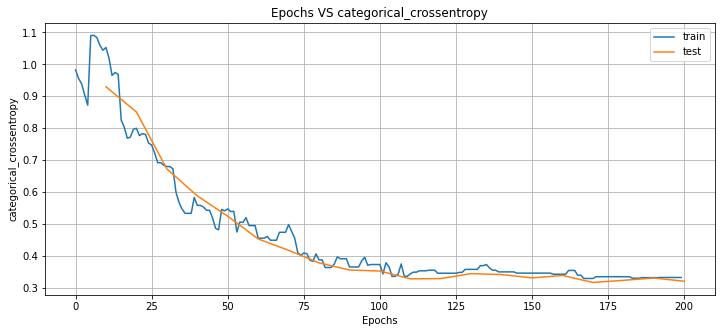

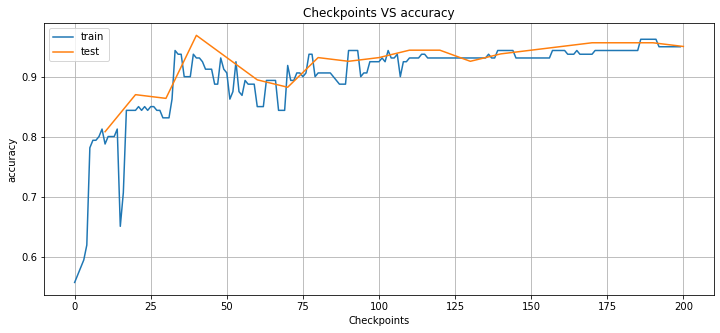

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_cce, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_acc, acc], x_label = 'Checkpoints', \
    y_label = 'accuracy', legend=['train', 'test'])

In [12]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[0. 1. 0.] <-> [0.49065164 0.4823211  0.02702729]
[1. 0. 0.] <-> [0.8241834  0.04404015 0.13177644]
[0. 1. 0.] <-> [0.23575127 0.75367814 0.0105706 ]
[1. 0. 0.] <-> [0.80578244 0.06137305 0.13284452]
[0. 0. 1.] <-> [0.2601547  0.01222499 0.7276203 ]
[0. 0. 1.] <-> [0.24952473 0.00942112 0.7410541 ]
[1. 0. 0.] <-> [0.77133614 0.15106435 0.07759954]
[1. 0. 0.] <-> [0.70358163 0.04068654 0.25573182]
[1. 0. 0.] <-> [0.7734585  0.16425878 0.06228277]
[0. 0. 1.] <-> [0.2618033  0.00970508 0.7284916 ]
[1. 0. 0.] <-> [0.84673333 0.05920495 0.0940617 ]
[1. 0. 0.] <-> [0.8008554  0.12021535 0.07892919]
[0. 1. 0.] <-> [0.26858523 0.7183559  0.0130589 ]
[1. 0. 0.] <-> [0.80150825 0.08888016 0.10961158]
[1. 0. 0.] <-> [0.80498713 0.10807128 0.08694159]
[0. 1. 0.] <-> [0.53054434 0.4401969  0.0292587 ]
[1. 0. 0.] <-> [0.8068238  0.04484915 0.1483271 ]
[1. 0. 0.] <-> [0.8272962  0.08950353 0.08320029]
[1. 0. 0.] <-> [0.779468   0.14693472 0.07359732]
[1. 0. 0.] <-> [0.8187391  0.05851058 0.12275022]


In [13]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.808641975308642, 'mean_square_error': 0.4734695667070427, 'categorical_crossentropy': 0.929828926368996, 'essential_metrics': {0: {'tp_hit': 76, 'fp_hit': 24, 'tn_hit': 4, 'fn_hit': 4}, 1: {'tp_hit': 1, 'fp_hit': 7, 'tn_hit': 86, 'fn_hit': 14}, 2: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 95, 'fn_hit': 13}}, 'checkpoint': 10} 


{'accuracy': 0.8703703703703703, 'mean_square_error': 0.484491387051306, 'categorical_crossentropy': 0.8508549442997685, 'essential_metrics': {0: {'tp_hit': 75, 'fp_hit': 13, 'tn_hit': 15, 'fn_hit': 5}, 1: {'tp_hit': 12, 'fp_hit': 3, 'tn_hit': 90, 'fn_hit': 3}, 2: {'tp_hit': 0, 'fp_hit': 5, 'tn_hit': 90, 'fn_hit': 13}}, 'checkpoint': 20} 


{'accuracy': 0.8641975308641975, 'mean_square_error': 0.3576605650830597, 'categorical_crossentropy': 0.672580153853805, 'essential_metrics': {0: {'tp_hit': 80, 'fp_hit': 16, 'tn_hit': 12, 'fn_hit': 0}, 1: {'tp_hit': 6, 'fp_hit': 6, 'tn_hit': 87, 'fn_hit': 9}, 2: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 95, 'fn_hit': 1

In [14]:
print(model)

Layer 1
Neuron 0: weights:
[-0.32545075  0.89148384  0.31137553 -0.71581674 -0.8591189 ]
 bias: 0.9765171408653259

Neuron 1: weights:
[ 0.32302418 -0.60706264 -0.17457682  0.43075082  0.51632893]
 bias: -0.3106807470321655

Neuron 2: weights:
[ 0.4567591  -1.2057079  -0.750227   -0.10347507  0.27014   ]
 bias: 0.6560513377189636

Neuron 3: weights:
[-0.37271497  1.1920367   0.78829604 -0.01784757 -0.17126843]
 bias: -0.43328946828842163

$
Layer 2
Neuron 0: weights:
[ 1.175406   -0.56297606  1.0023925  -0.8983291 ]
 bias: 0.0997314527630806

Neuron 1: weights:
[ 0.55922735 -1.0272336  -1.7597134   1.3552877 ]
 bias: -0.07572799921035767

Neuron 2: weights:
[-1.8341824   1.3912423   0.49604467 -0.887365  ]
 bias: -0.24622642993927002

$

